Circuit for Angel Encoding+Inverse QFT+SWAP test

Please use python 3.11!!

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np

In [17]:
from qiskit_aer import AerSimulator

In [18]:
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.decompose(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [19]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

In [20]:
# ----- run a quick simulation -----
backend = AerSimulator(method='statevector', device='GPU')
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")

⟨SWAP⟩  ≈ -0.0234
|⟨φ(y)|φ(x)⟩|² ≈ 0.4883


/tmp/ipykernel_30518/837596916.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_circ = QFT(9, do_swaps=False).inverse()


/tmp/ipykernel_30518/837596916.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_circ = QFT(9, do_swaps=False).inverse()


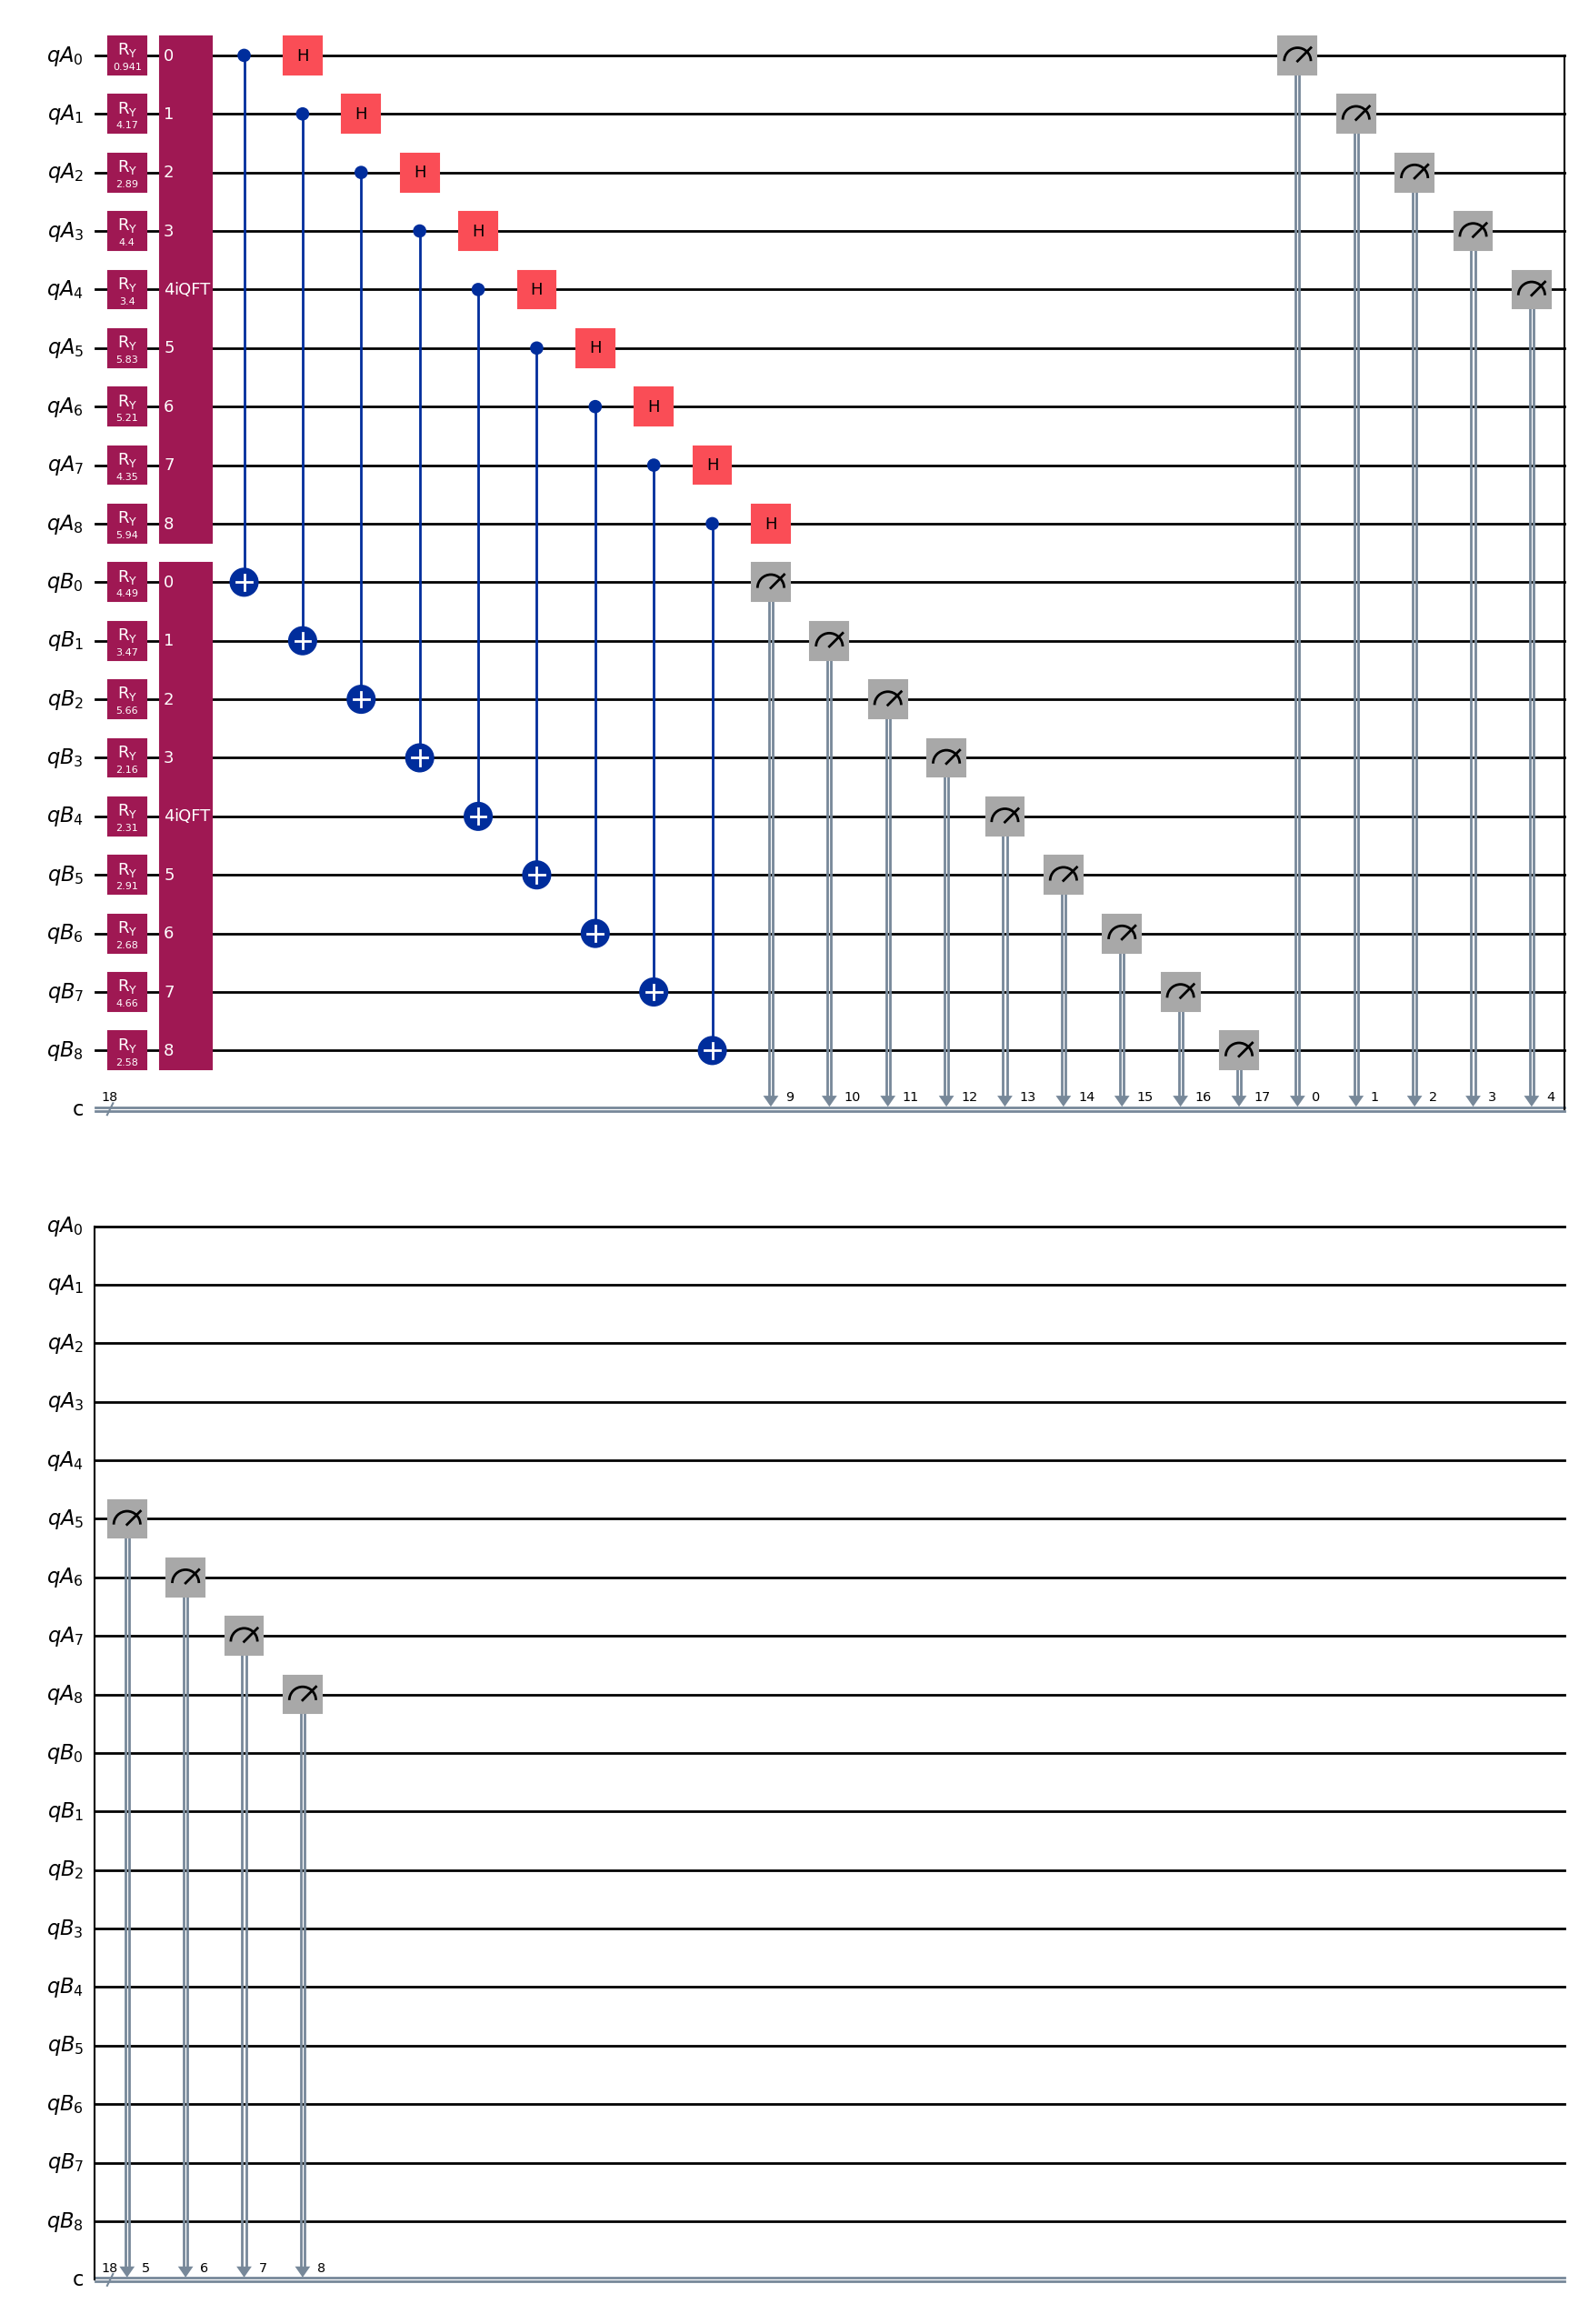

In [21]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

/tmp/ipykernel_30518/2376664632.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()


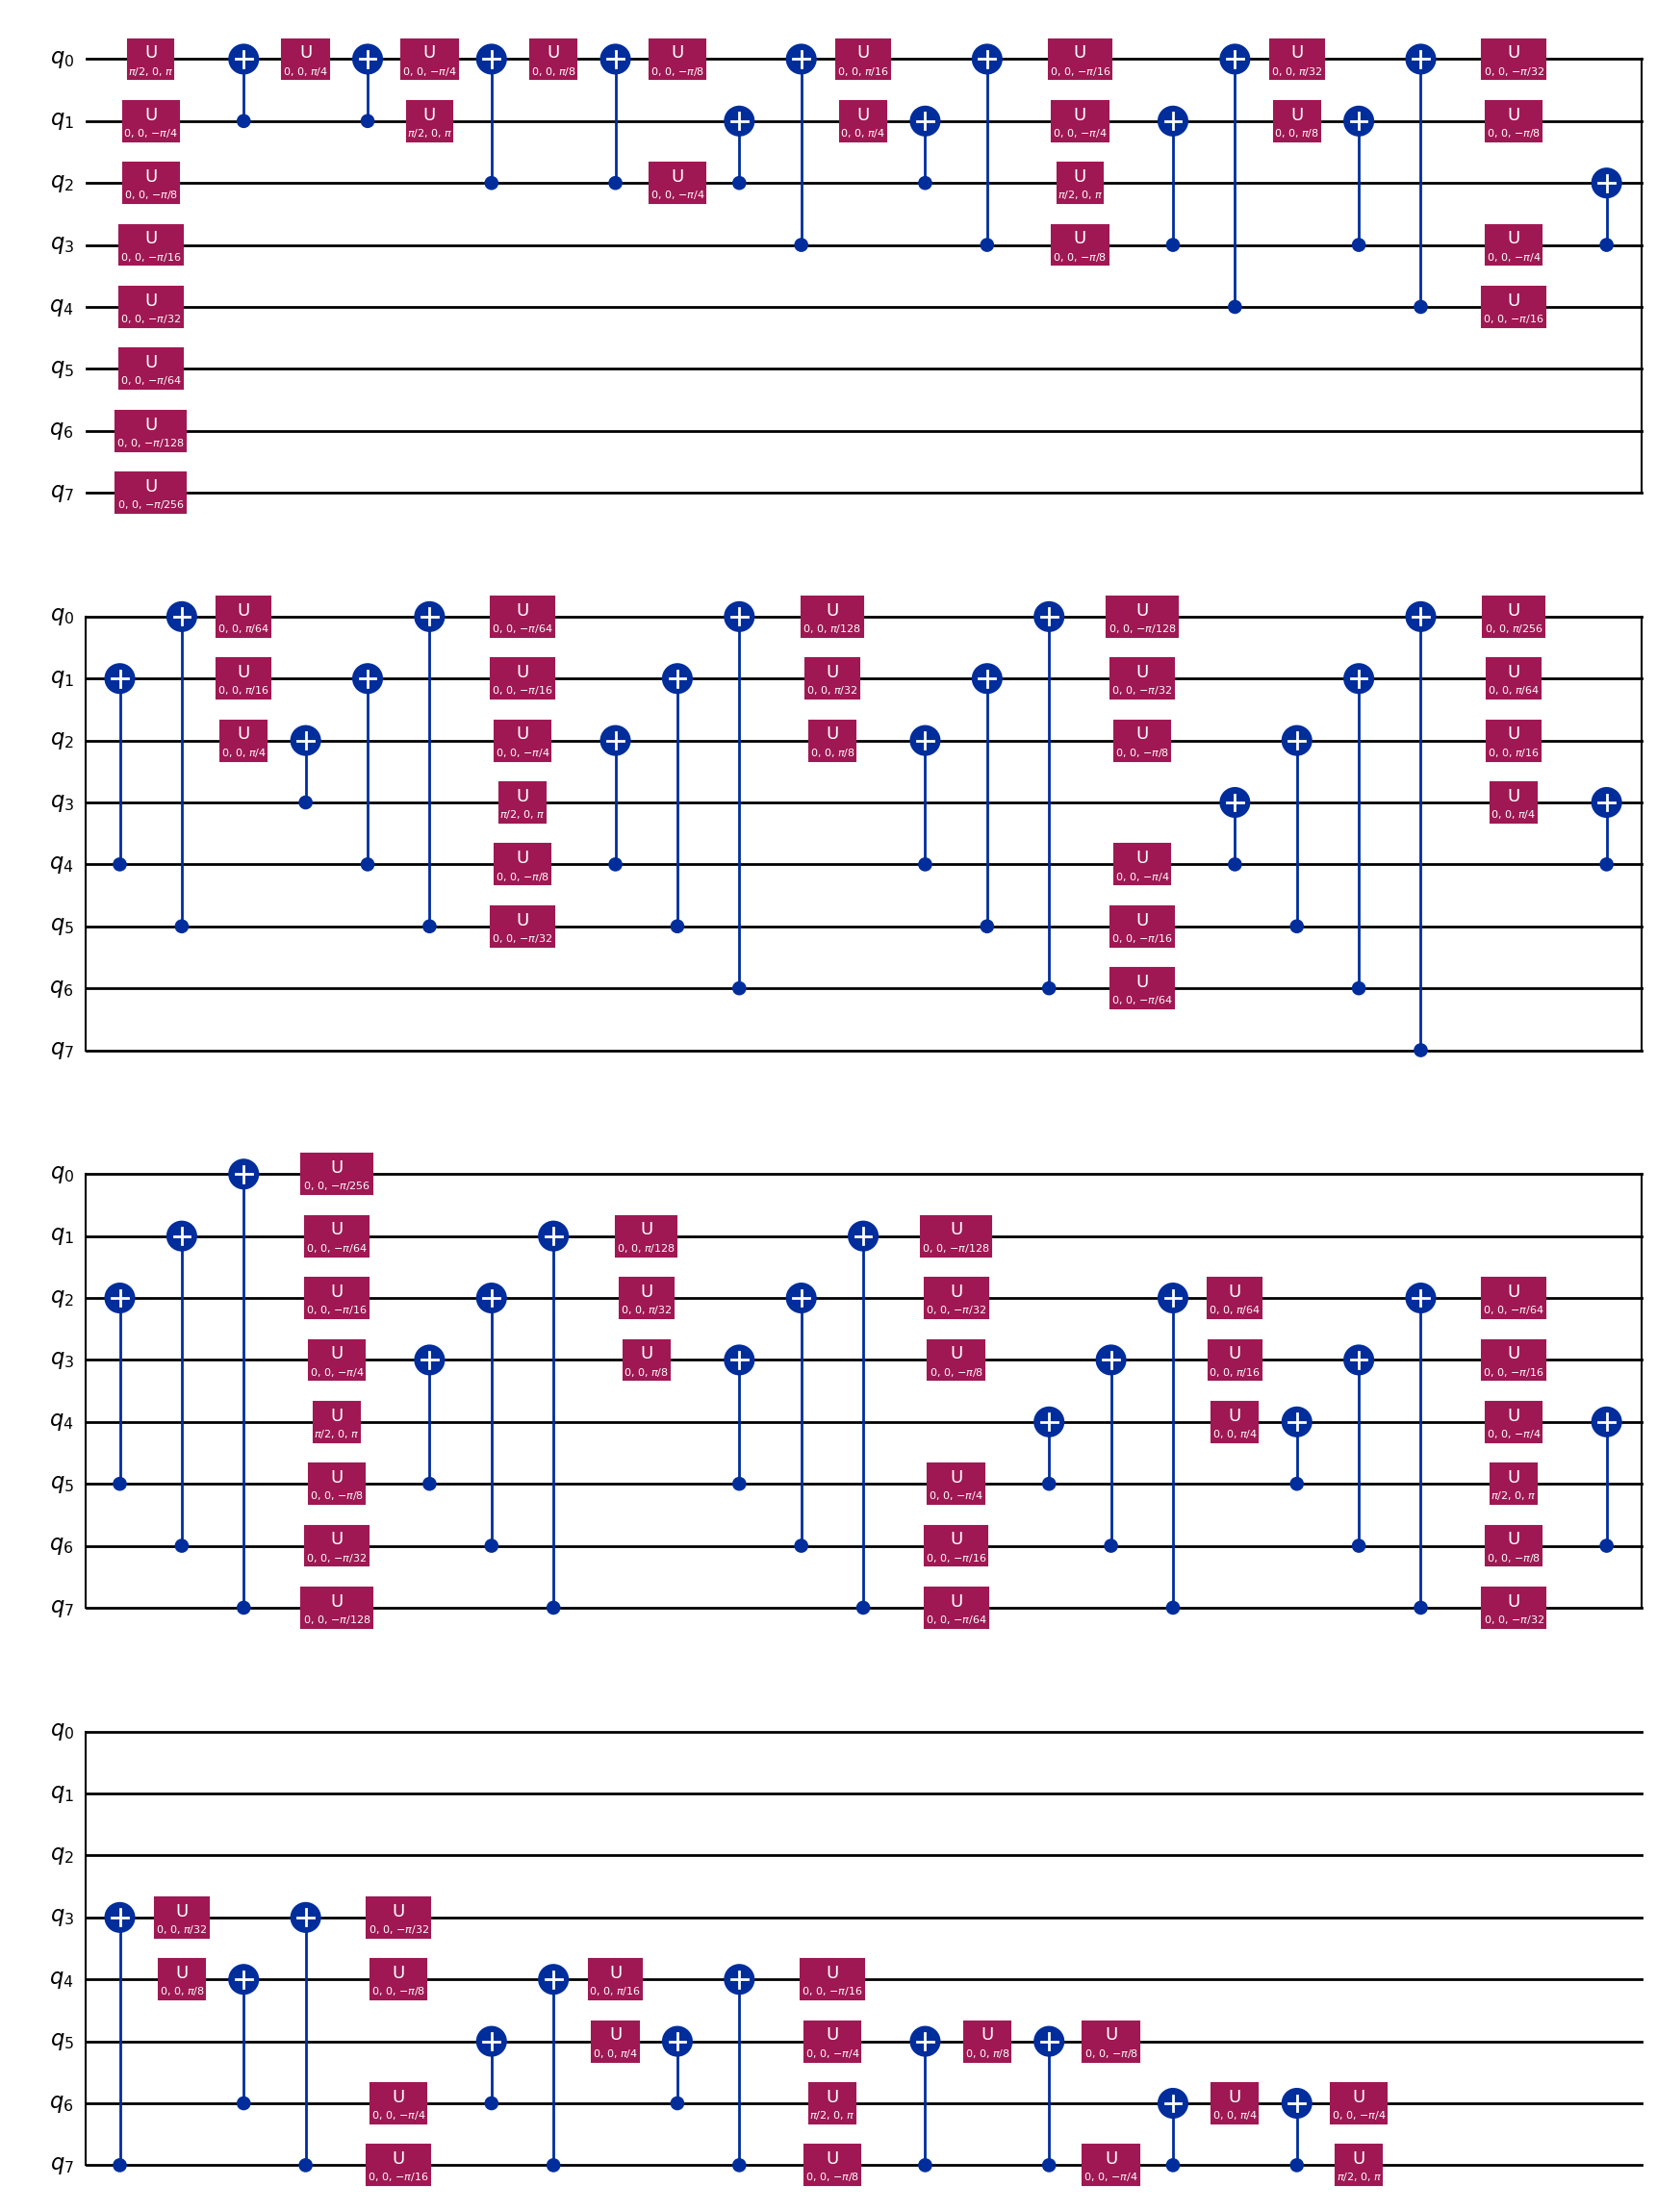

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Uses python 3.11

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ImportError: cannot import name 'convert_to_target' from 'qiskit.providers' (/home/user/work/quadrigems/.venv/lib/python3.12/site-packages/qiskit/providers/__init__.py)

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Please use python 3.11!!

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np

In [2]:
import os
pwd = os.environ.get('PWD', '.')
if path := os.environ.get('LD_LIBRARY_PATH'):
    os.environ['LD_LIBRARY_PATH'] = f"{pwd}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib:{path}"
else:
    os.environ['LD_LIBRARY_PATH'] = f"{pwd}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib"

In [72]:
%pip install pennylane-lightning-gpu

Note: you may need to restart the kernel to use updated packages.


In [73]:
%pip install pennylane-qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
qc = QuantumCircuit(2, 2)
qc.rx(np.pi, 0)
qc.measure_all()

import pennylane as qml
dev = qml.device('lightning.gpu', wires=20) 

@qml.qnode(dev)
def circuit():
    # Since measurements=None, the measurements present in the QuantumCircuit are returned.
    measurements = qml.from_qiskit(qc)()
    return [qml.expval(m) for m in measurements]

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py:201: PennyLaneDeprecationWarning: pennylane.DeviceError is no longer accessible at top-level                 and must be imported as pennylane.exceptions.DeviceError.                     Support for top-level access will be removed in v0.43.
  warnings.warn(
/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py:201: PennyLaneDeprecationWarning: pennylane.QuantumFunctionError is no longer accessible at top-level                 and must be imported as pennylane.exceptions.QuantumFunctionError.                     Support for top-level access will be removed in v0.43.
  warnings.warn(


ImportError: cannot import name 'QubitDevice' from 'pennylane' (/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py)

In [4]:
#import os
#os.environ["LD_LIBRARY_PATH"] = "1"

In [5]:
!echo $PWD
!echo $LD_LIBRARY_PATH
!export LD_LIBRARY_PATH="${PWD}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib:${LD_LIBRARY_PATH}"
!echo $PWD
!echo $LD_LIBRARY_PATH
!echo $HOME

/home/user/work/quadrigems
/home/user/work/quadrigems/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib
/home/user/work/quadrigems
/home/user/work/quadrigems/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib
/home/user


In [6]:
from qiskit_aer import AerSimulator

In [7]:
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.decompose(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [8]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

In [9]:
# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")

⟨SWAP⟩  ≈ 0.0508
|⟨φ(y)|φ(x)⟩|² ≈ 0.5254


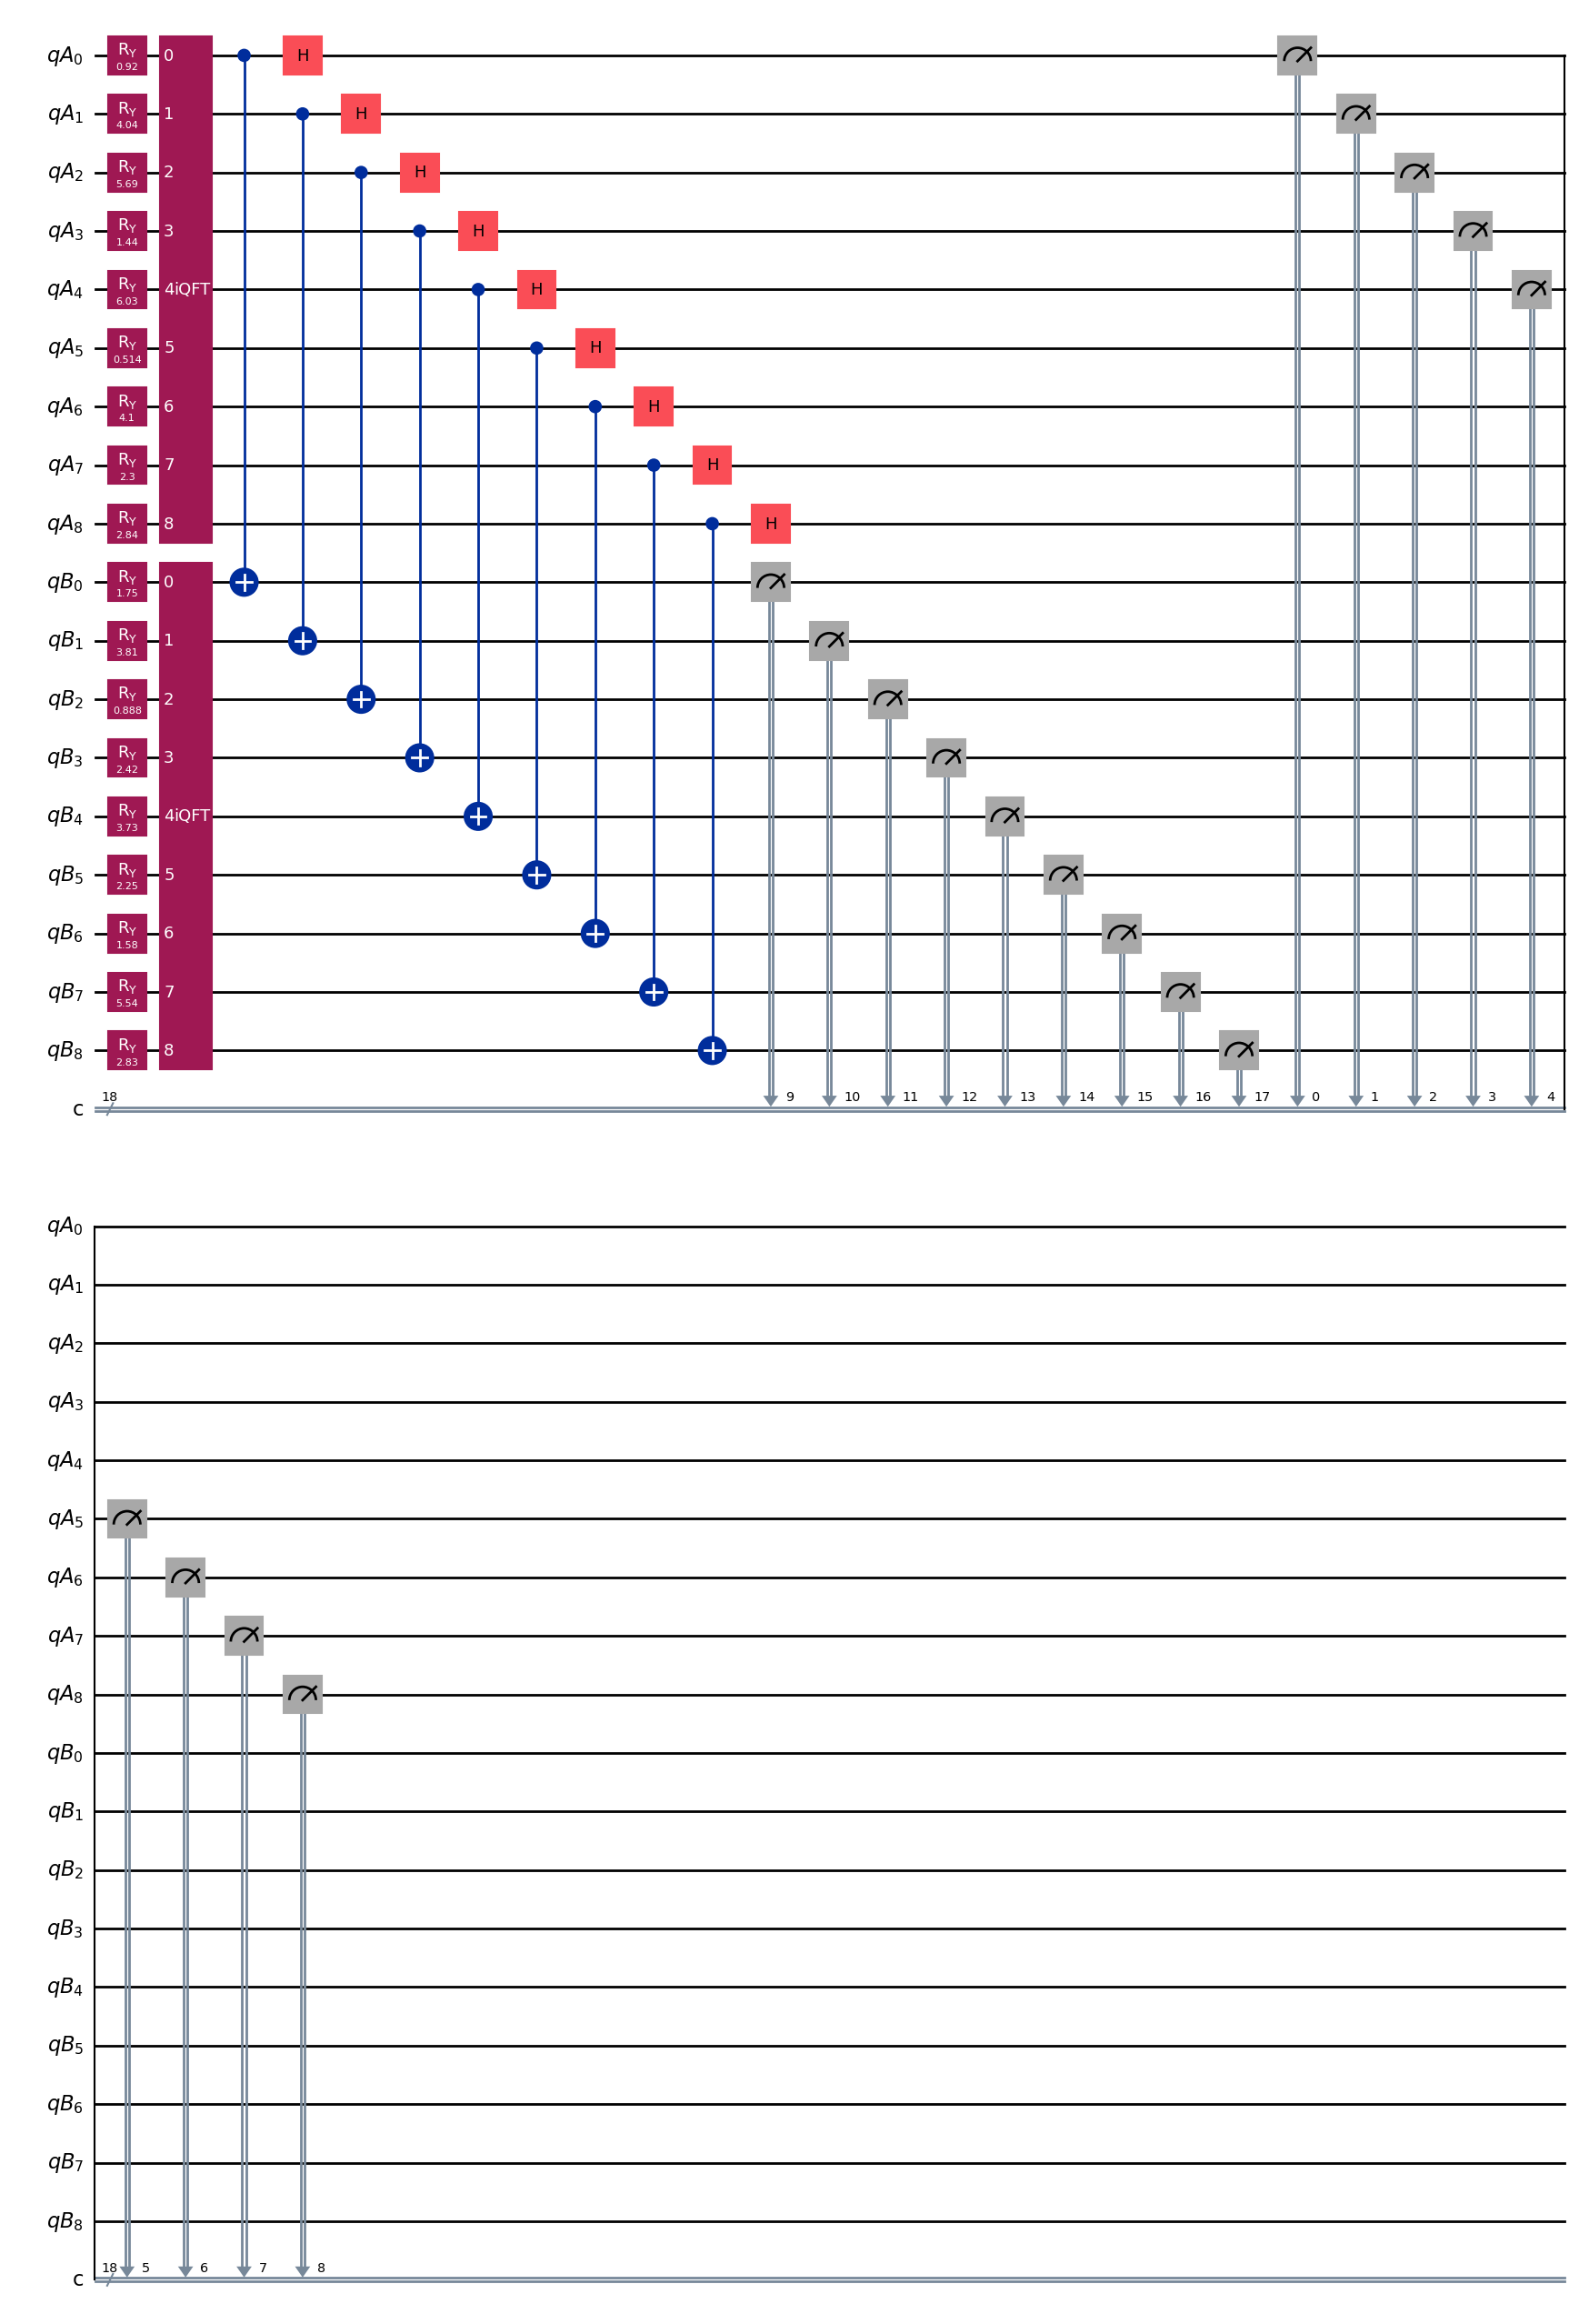

In [13]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Uses python 3.11

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ImportError: cannot import name 'convert_to_target' from 'qiskit.providers' (/home/user/work/quadrigems/.venv/lib/python3.12/site-packages/qiskit/providers/__init__.py)

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Please use python 3.11!!

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np

In [17]:
from qiskit_aer import AerSimulator

In [18]:
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.decompose(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [19]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

In [20]:
# ----- run a quick simulation -----
backend = AerSimulator(method='statevector', device='GPU')
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")

⟨SWAP⟩  ≈ -0.0234
|⟨φ(y)|φ(x)⟩|² ≈ 0.4883


/tmp/ipykernel_30518/837596916.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_circ = QFT(9, do_swaps=False).inverse()


/tmp/ipykernel_30518/837596916.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_circ = QFT(9, do_swaps=False).inverse()


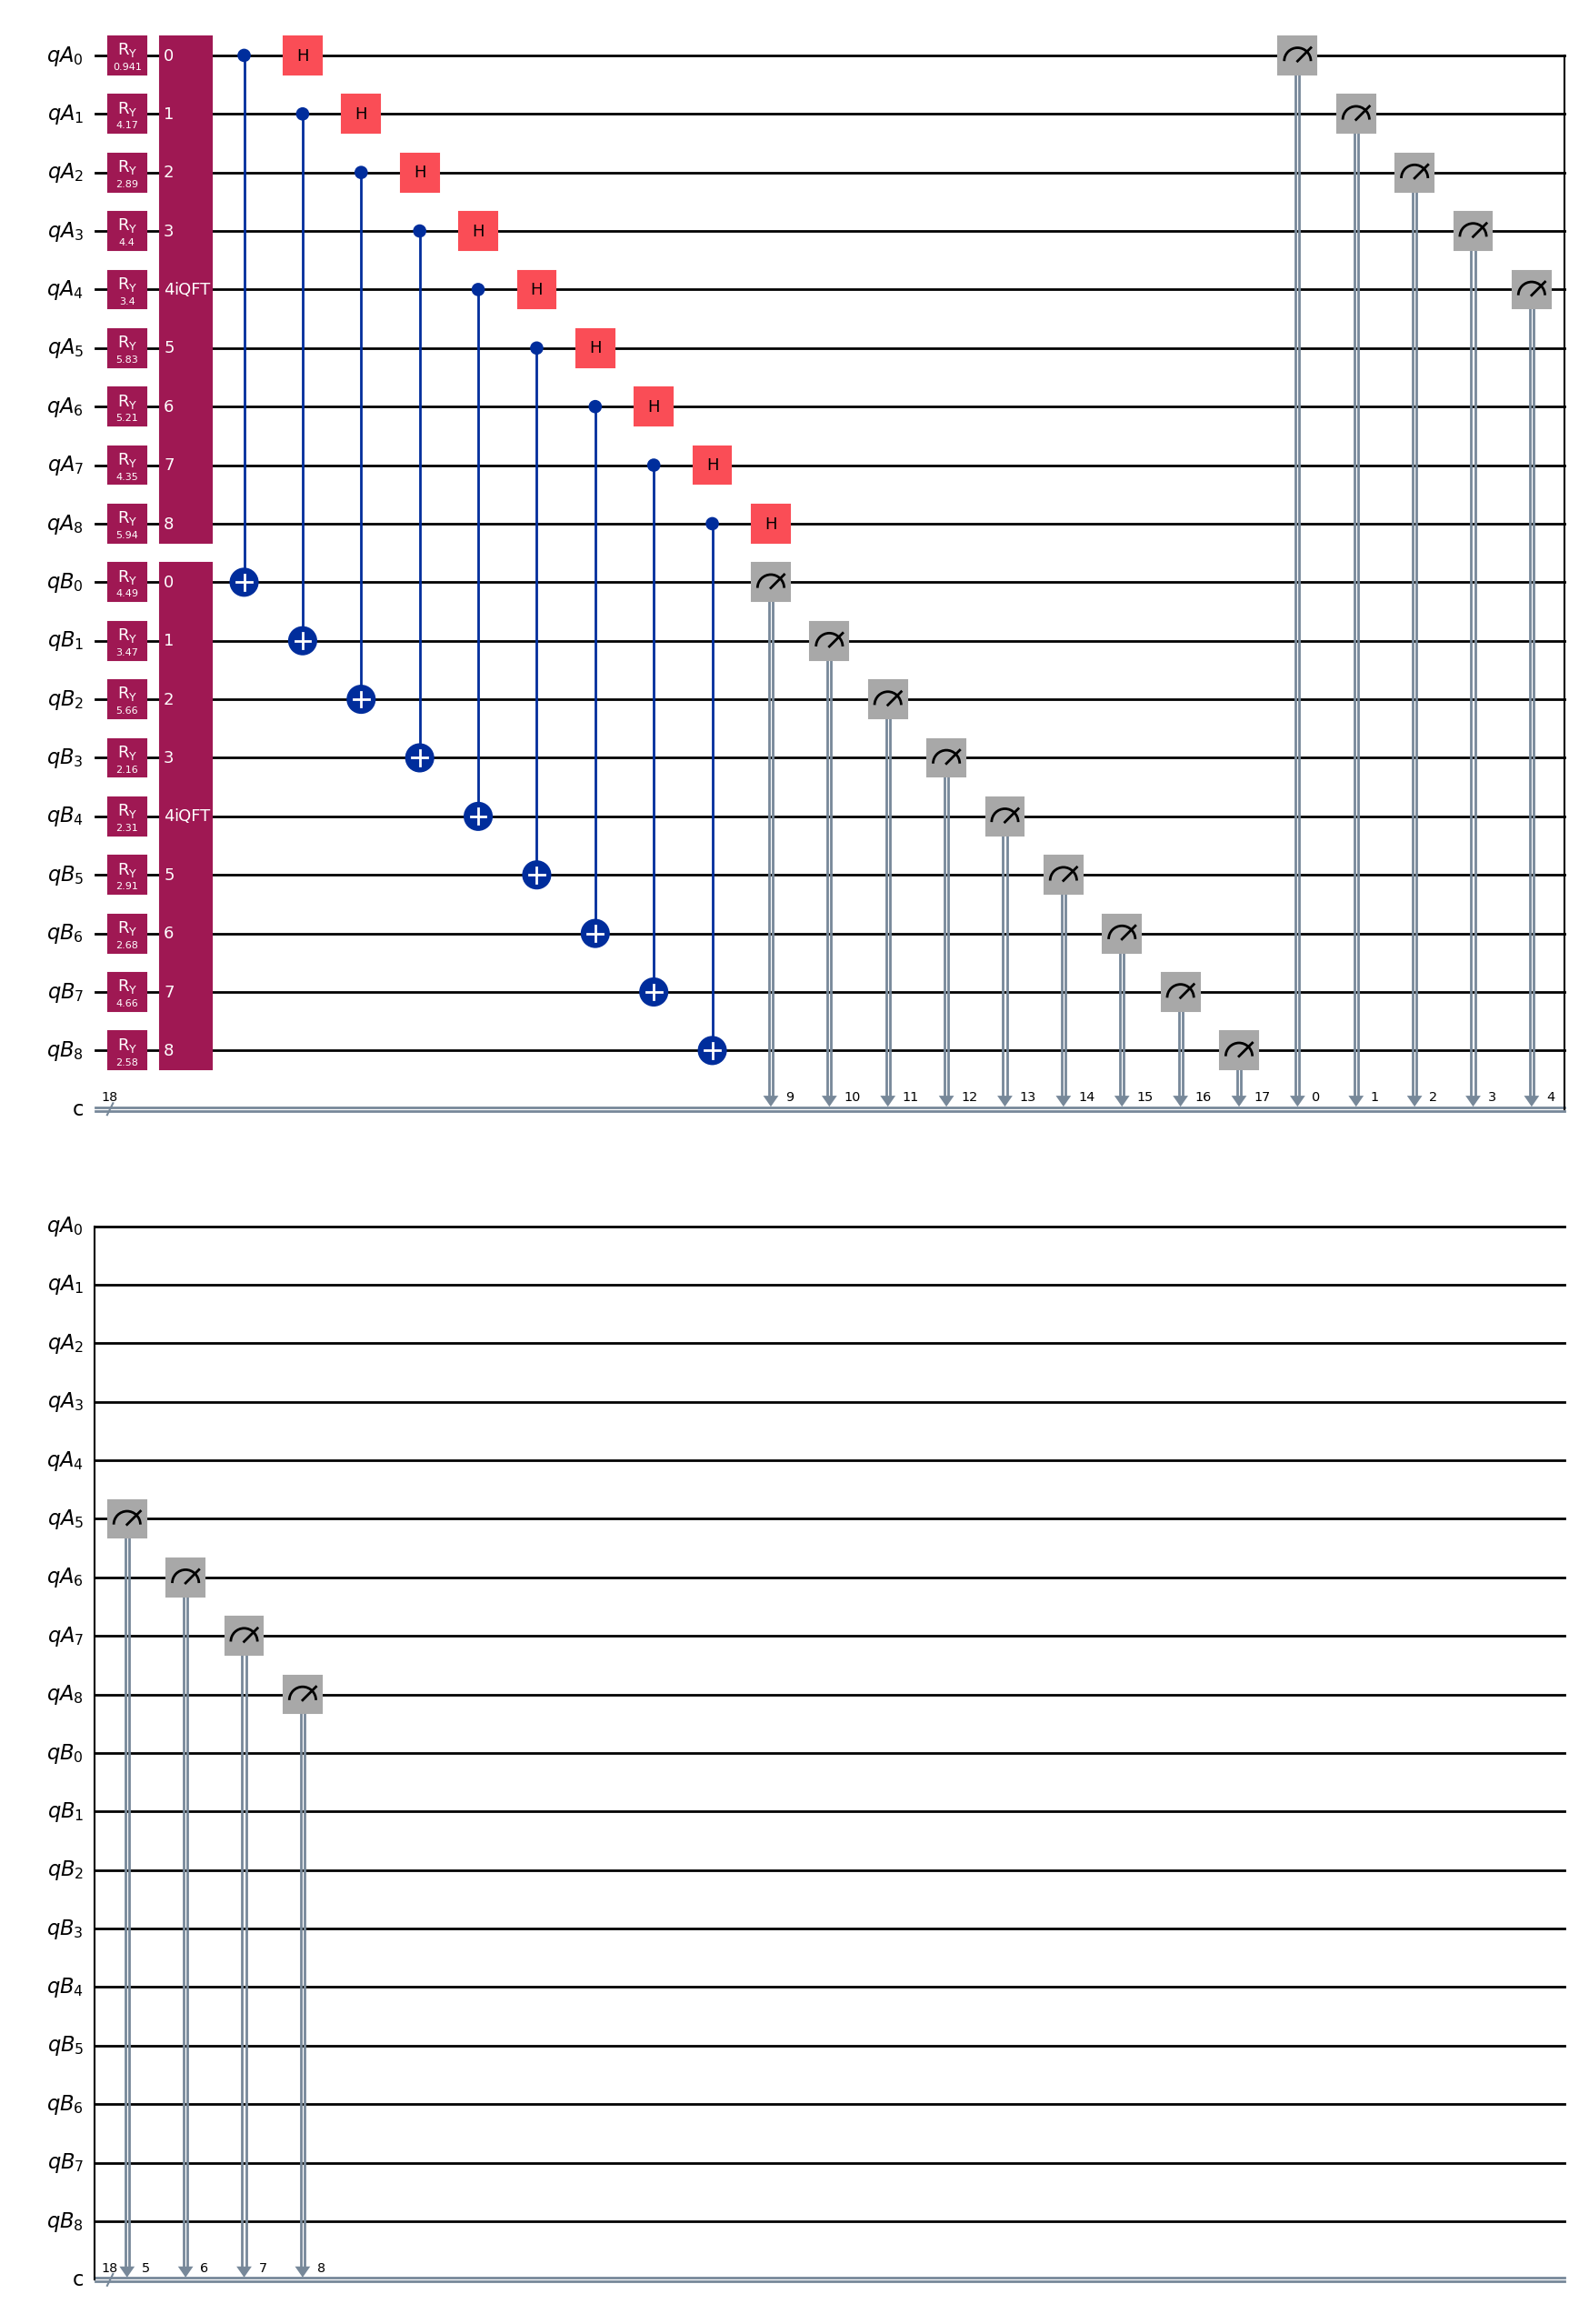

In [21]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

/tmp/ipykernel_30518/2376664632.py:8: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()


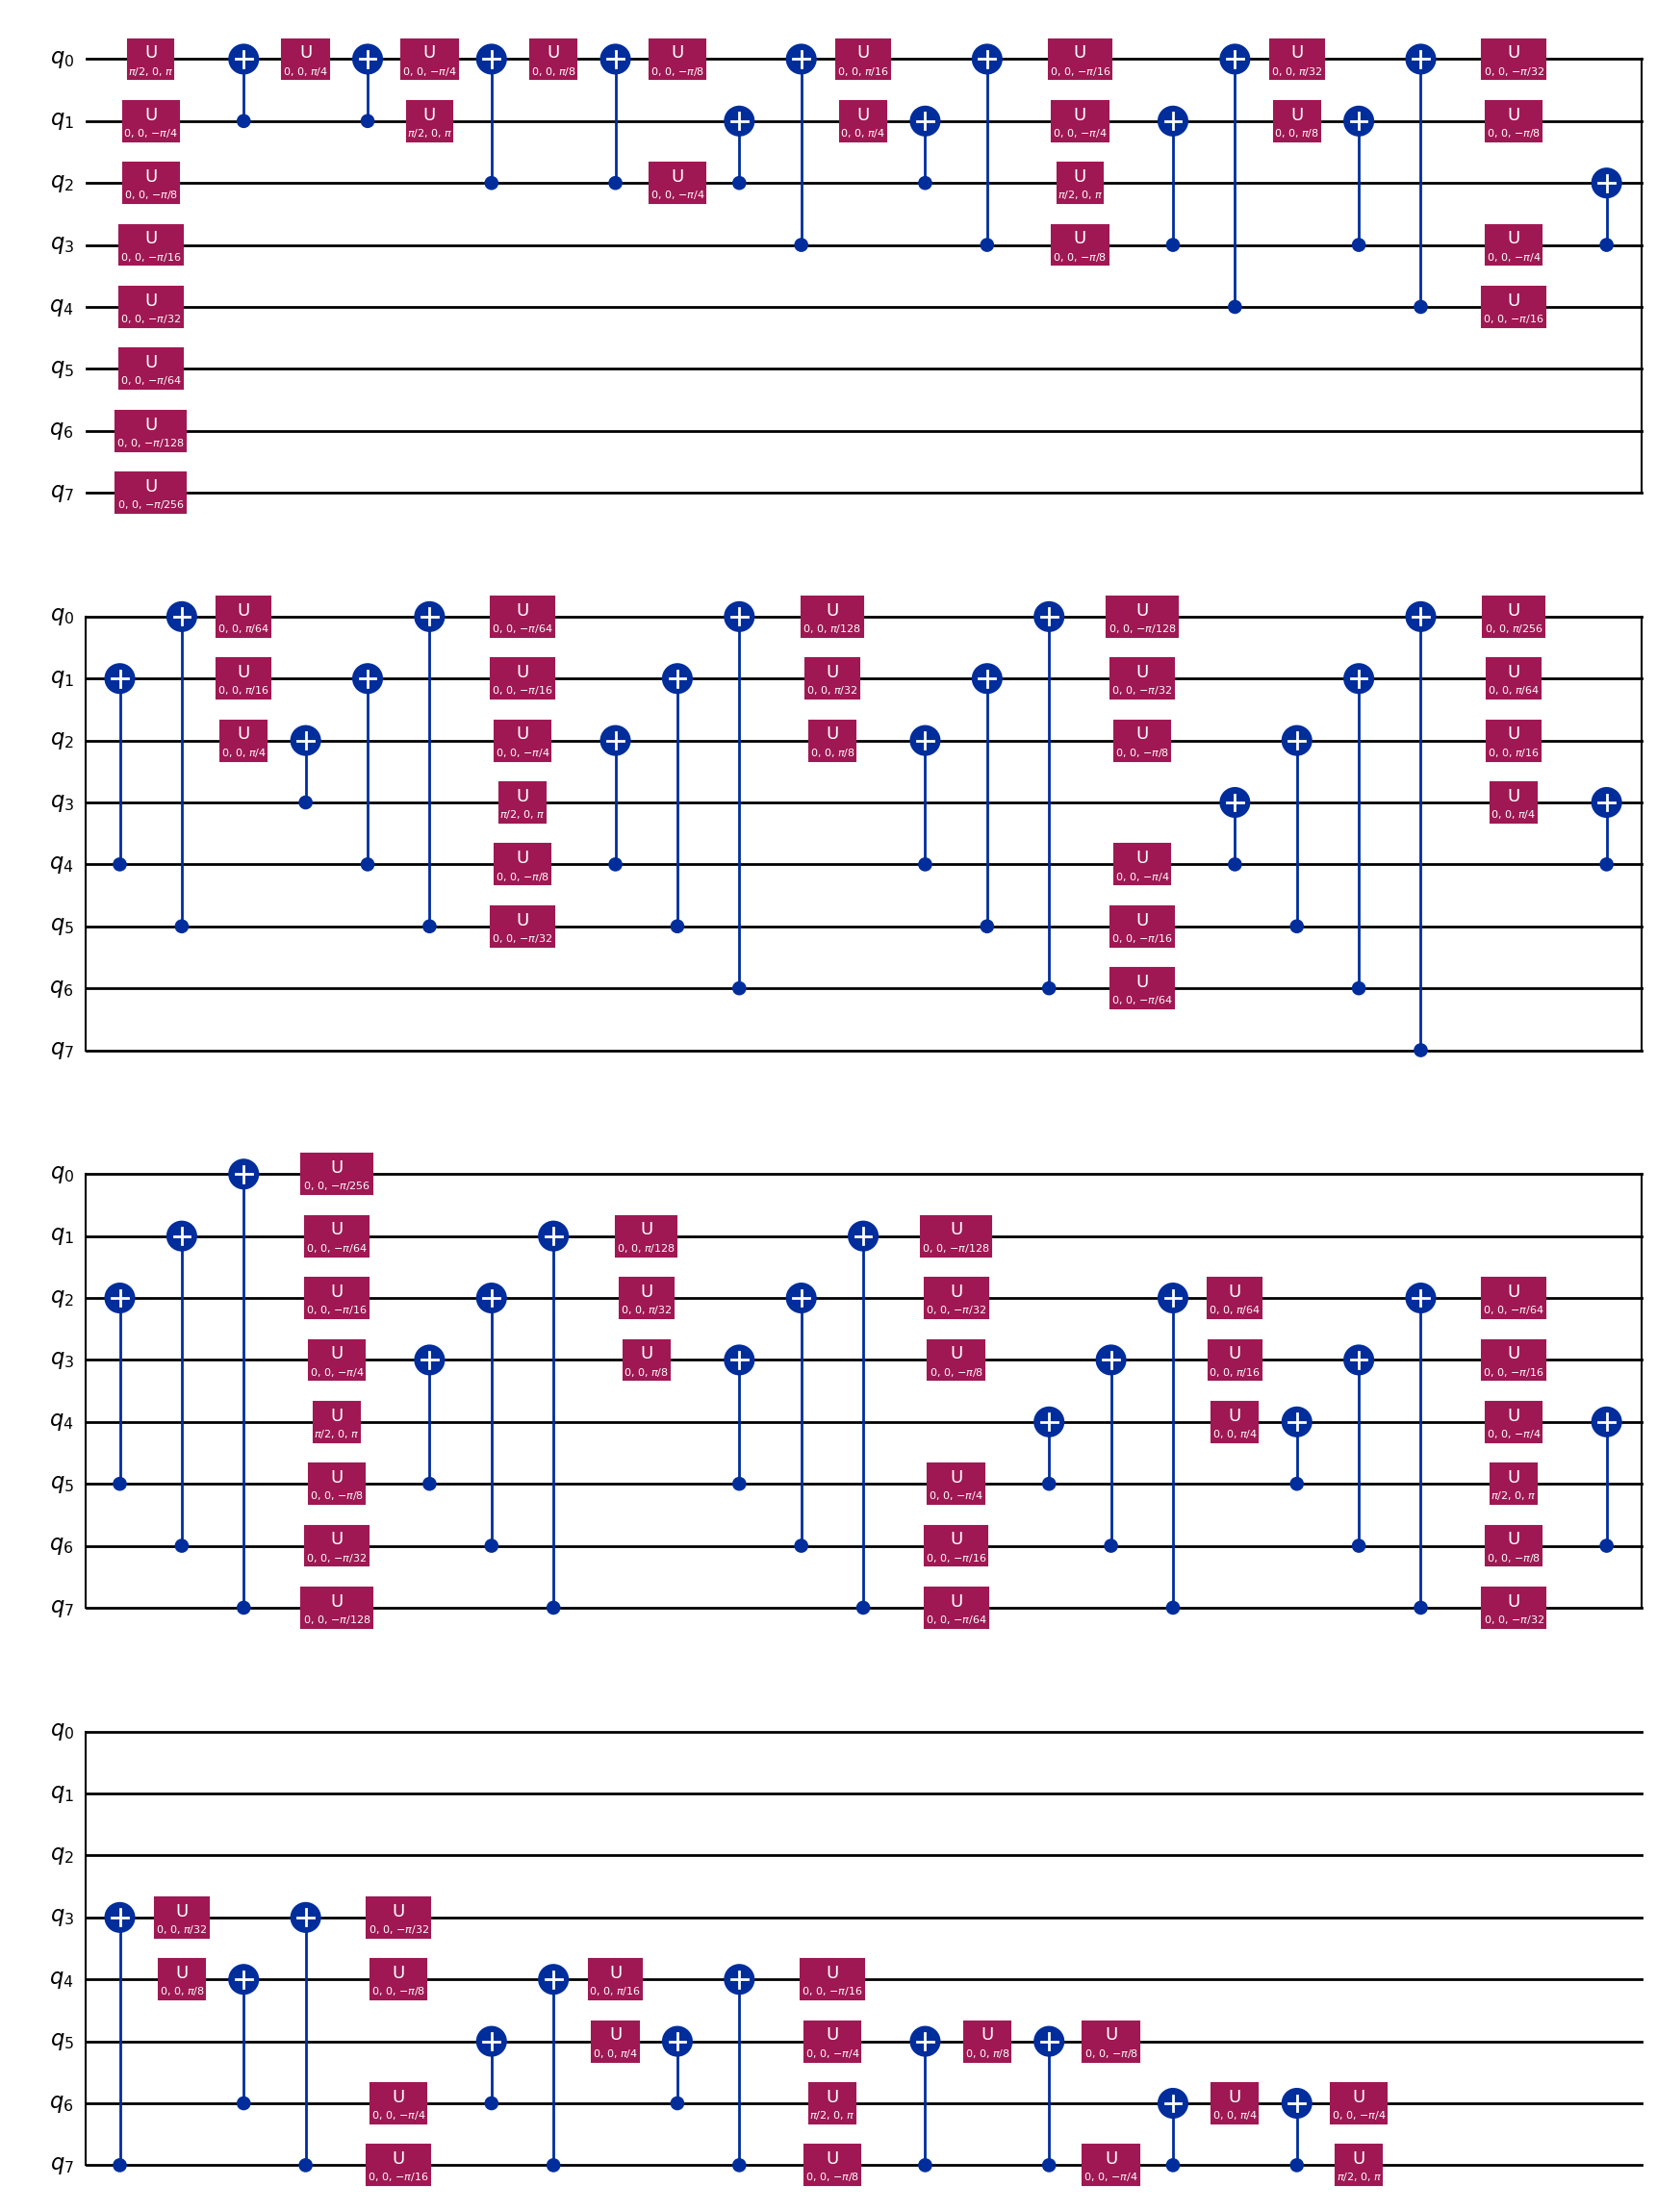

In [15]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Uses python 3.11

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ImportError: cannot import name 'convert_to_target' from 'qiskit.providers' (/home/user/work/quadrigems/.venv/lib/python3.12/site-packages/qiskit/providers/__init__.py)

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Please use python 3.11!!

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np

In [2]:
import os
pwd = os.environ.get('PWD', '.')
if path := os.environ.get('LD_LIBRARY_PATH'):
    os.environ['LD_LIBRARY_PATH'] = f"{pwd}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib:{path}"
else:
    os.environ['LD_LIBRARY_PATH'] = f"{pwd}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib"

In [72]:
%pip install pennylane-lightning-gpu

Note: you may need to restart the kernel to use updated packages.


In [73]:
%pip install pennylane-qiskit

Note: you may need to restart the kernel to use updated packages.


In [3]:
qc = QuantumCircuit(2, 2)
qc.rx(np.pi, 0)
qc.measure_all()

import pennylane as qml
dev = qml.device('lightning.gpu', wires=20) 

@qml.qnode(dev)
def circuit():
    # Since measurements=None, the measurements present in the QuantumCircuit are returned.
    measurements = qml.from_qiskit(qc)()
    return [qml.expval(m) for m in measurements]

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py:201: PennyLaneDeprecationWarning: pennylane.DeviceError is no longer accessible at top-level                 and must be imported as pennylane.exceptions.DeviceError.                     Support for top-level access will be removed in v0.43.
  warnings.warn(
/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py:201: PennyLaneDeprecationWarning: pennylane.QuantumFunctionError is no longer accessible at top-level                 and must be imported as pennylane.exceptions.QuantumFunctionError.                     Support for top-level access will be removed in v0.43.
  warnings.warn(


ImportError: cannot import name 'QubitDevice' from 'pennylane' (/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/pennylane/__init__.py)

In [4]:
#import os
#os.environ["LD_LIBRARY_PATH"] = "1"

In [5]:
!echo $PWD
!echo $LD_LIBRARY_PATH
!export LD_LIBRARY_PATH="${PWD}/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib:${LD_LIBRARY_PATH}"
!echo $PWD
!echo $LD_LIBRARY_PATH
!echo $HOME

/home/user/work/quadrigems
/home/user/work/quadrigems/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib
/home/user/work/quadrigems
/home/user/work/quadrigems/.venv/lib64/python3.12/site-packages/nvidia/nvjitlink/lib
/home/user


In [6]:
from qiskit_aer import AerSimulator

In [7]:
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.decompose(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [8]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

In [9]:
# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")

⟨SWAP⟩  ≈ 0.0508
|⟨φ(y)|φ(x)⟩|² ≈ 0.5254


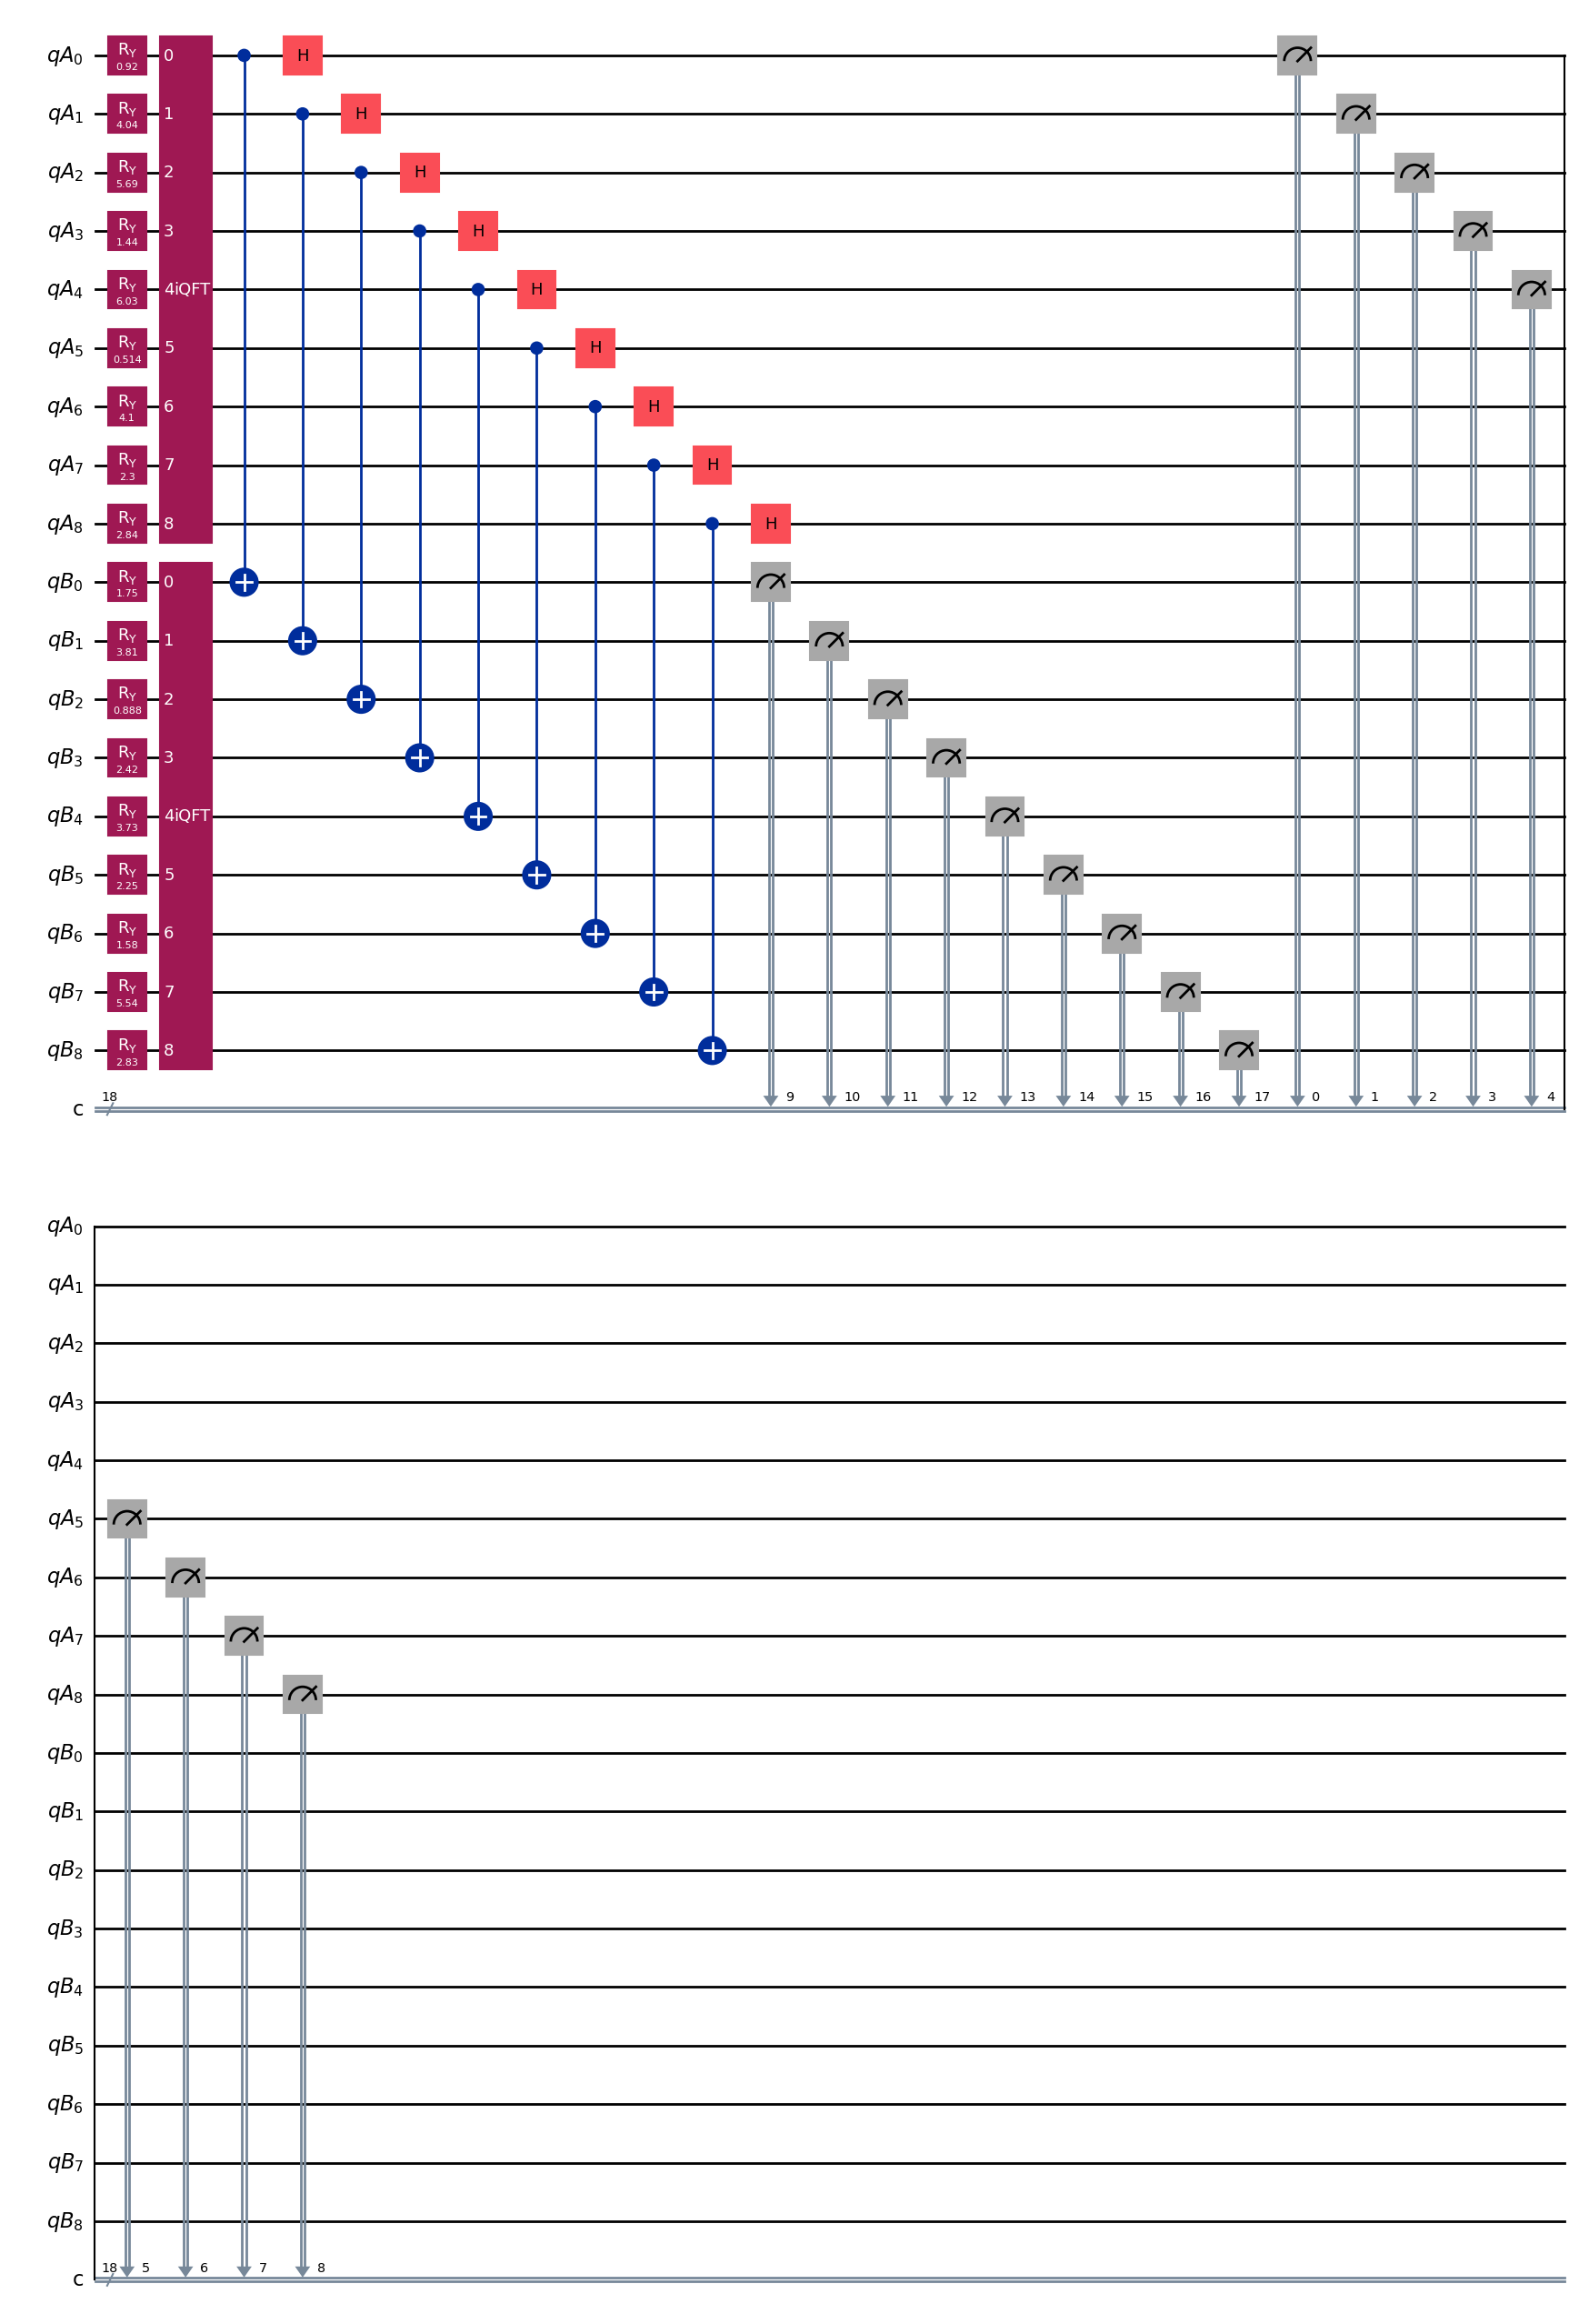

In [13]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

Uses python 3.11

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator

def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)

def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)

def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)

    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ImportError: cannot import name 'convert_to_target' from 'qiskit.providers' (/home/user/work/quadrigems/.venv/lib/python3.12/site-packages/qiskit/providers/__init__.py)

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl')

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


ModuleNotFoundError: No module named 'qiskit_aer'

In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')


Circuit for Angel Encoding+Inverse QFT+SWAP test

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator
def angle_embedding(circ, qubits, vec):
    """Simple Ry angle encoding."""
    for q, theta in zip(qubits, vec):
        circ.ry(theta, q)
def inverse_qft(circuit, qubits):
    """Apply inverse QFT."""
    qft_circ = QFT(9, do_swaps=False).inverse()
    qft_circ.name = 'iQFT'
    circuit.append(qft_circ.to_gate(), qubits)
def swap_diagonal_test(data1, data2):
    assert len(data1) == len(data2) == 9
    qA = QuantumRegister(9, 'qA')          # |φ(→y)⟩
    qB = QuantumRegister(9, 'qB')          # |φ(→x)⟩
    c   = ClassicalRegister(18, 'c')
    qc  = QuantumCircuit(qA, qB, c)

    # 1. Encode both feature vectors
    angle_embedding(qc, qA, data1)
    angle_embedding(qc, qB, data2)
    inverse_qft(qc, qA)
    inverse_qft(qc, qB)
    # 2. Diagonalise SWAP : CNOT (A→B) + H on A
    for i in range(9):
        qc.cx(qA[i], qB[i])
        qc.h(qA[i])

    # 3. Measure every qubit
    for i in range(9):
        qc.measure(qA[i], c[i])       # s_i results
        qc.measure(qB[i], c[9+i])     # t_i results
    return qc


In [ ]:
def swap_expectation(counts, n_pairs=9):
    """
    Turn raw measurement `counts` into  ⟨SWAP⟩  and overlap |⟨φ(y)|φ(x)⟩|².
    counts  : dict  bitstring -> frequency   (keys length = 2*n_pairs)
    Returns : (⟨SWAP⟩,  fidelity_estimate)
    """
    total = sum(counts.values())
    exp_swap = 0.0
    for bitstring, freq in counts.items():
        # Qiskit prints qubits little-endian; reverse to pair them as (s_i,t_i)
        bits = bitstring[::-1]
        m = 0                                 # number of |11⟩ pairs
        for i in range(n_pairs):
            if bits[i] == '1' and bits[n_pairs+i] == '1':
                m += 1
        eigenvalue = (-1)**m
        exp_swap  += eigenvalue * freq / total
    fidelity = (1.0 + exp_swap) / 2.0
    return exp_swap, fidelity

# ----- run a quick simulation -----
backend = AerSimulator()
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc = qc.decompose()              # for Aer 0.12+
qc.save_statevector()

shots = 4096
# compiled_circuit = transpile(qc, backend)
job = backend.run(qc).result()
counts = job.get_counts()

exp_swap, fidelity = swap_expectation(counts)
print(f"⟨SWAP⟩  ≈ {exp_swap:.4f}")
print(f"|⟨φ(y)|φ(x)⟩|² ≈ {fidelity:.4f}")


In [ ]:
data1 = np.random.uniform(0, 2*np.pi, 9)
data2 = np.random.uniform(0, 2*np.pi, 9)

qc = swap_diagonal_test(data1, data2)
qc.draw('mpl') 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

# Number of qubits
n_qubits = 8

# Create the inverse QFT circuit directly and decompose it
iqft_circuit = QFT(n_qubits, do_swaps=False).inverse()
iqft_circuit = iqft_circuit.decompose(reps=5)  # force deeper decomposition

# Draw the decomposed iQFT circuit
iqft_circuit.draw('mpl')  # or 'text' for terminal


In [ ]:
# qc=iqft_circuit
# Analyze the circuit
width = qc.width()
depth = qc.depth()
total_gates = qc.size()
non_local_gates = sum(1 for instr, qargs, cargs in qc.data if len(qargs) > 1)

# Prepare results table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

circuit_info = pd.DataFrame({
    "Circuit Name": ["Swap Test + iQFT"],
    "Width": [width],
    "Depth": [depth],
    "Total Gates": [total_gates],
    "Non-local Gates": [non_local_gates]
})

circuit_info

Circuit for Amplitude Encoding+Neighbor Entanglement+Compute/Uncompute

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal
import numpy as np
from qiskit.circuit.library import Initialize

def normalize(vec):
    """Normalize a real vector for amplitude encoding."""
    norm = np.linalg.norm(vec)
    return vec / norm
    
def amplitude_encode(circuit, qubits, data):
    """Prepare the amplitude-encoded quantum state."""
    init_gate = Initialize(data)
    init_gate.label = "AmpEncode"
    circuit.append(init_gate, qubits)

def entangle_nearest_neighbor(circuit, qubits):
    """Apply nearest-neighbor CNOT entanglement."""
    for i in range(len(qubits)-1):
        circuit.cx(qubits[i], qubits[i+1])

def compute_uncompute_circuit(data1, data2):
    """Construct the full compute-uncompute quantum similarity test circuit."""
    assert len(data1) == len(data2)
    num_qubits = int(np.ceil(np.log2(len(data1))))
    dim = 2**num_qubits

    # Pad input vectors to next power of 2
    padded_data1 = np.zeros(dim)
    padded_data2 = np.zeros(dim)
    padded_data1[:len(data1)] = normalize(data1)
    padded_data2[:len(data2)] = normalize(data2)

    # Registers
    qA = QuantumRegister(num_qubits, name="qA")  # |ψ⟩
    qB = QuantumRegister(num_qubits, name="qB")  # |φ⟩
    c = ClassicalRegister(num_qubits, name="c")
    qc = QuantumCircuit(qA, qB, c)

    # Encode both states
    amplitude_encode(qc, qA, padded_data1)
    amplitude_encode(qc, qB, padded_data2)

    # Apply entanglement to both
    entangle_nearest_neighbor(qc, qA)
    entangle_nearest_neighbor(qc, qB)

    # Apply compute (unitary U)
    U = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=1)
    for i in range(3):
        qc.h(qA[i])
        qc.h(qB[i])
    qc.append(U.to_gate(label="U"), qA)
    qc.append(U.to_gate(label="U"), qB)
    for i in range(3):
        qc.h(qA[i])
    # Apply uncompute (U†) to qB only
    qc.append(U.inverse().to_gate(label="U†"), qB)
    for i in range(3):
        qc.h(qB[i])
    # Measure qB — if it's back to |0⟩, states are likely similar
    qc.measure(qB, c)

    return qc


In [ ]:
data1 = np.random.rand(5)
data2 = np.random.rand(5)
qc = compute_uncompute_circuit(data1, data2)
qc.draw('mpl')
